In [3]:
import os, glob
import pandas as pd
from rdkit import Chem
#from rdkit.Chem import PandasTools
import ast

pd.options.mode.chained_assignment = None

In [4]:
import rdkit

print(rdkit.__version__)

2023.09.6


In [5]:
from rdkit import rdBase

# Suppress RDKit warnings and running information
rdBase.DisableLog('rdApp.warning')  # Disable warnings
rdBase.DisableLog('rdApp.info')  # Disable info messages

In [6]:
import sys
sys.path.append('../')

from src.utils.mol_utils import get_inchi_noStereo_from_smi, get_inchi_noStereo_from_mol

ModuleNotFoundError: No module named 'src'

In [5]:
pd.set_option('display.max_rows', 20)

# load data sets

## load annotated AZ public data

In [6]:
az_public_df = pd.read_csv('../data/az_public_share/az_public_annotation_nodupGroups.csv')
len(az_public_df)

215

In [7]:
az_public_df.columns

Index(['mol_id', 'preprocessed_smi', 'soms', 'certain'], dtype='object')

## load preprocessed MetaQSAR

In [8]:
# preprocessed MetaQSAR set
metaqsar_df = PandasTools.LoadSDF('../data/metaqsar/db_preprocessed_mw_update.sdf',removeHs=False)
len(metaqsar_df)

1926

In [9]:
metaqsar_df['soms_new'] = metaqsar_df['soms_new'].map(ast.literal_eval)
metaqsar_df['soms_uncertain_new'] = metaqsar_df['soms_uncertain_new'].map(ast.literal_eval)

In [10]:
metaqsar_df.columns

Index(['name', 'mol_id', 'inchi_new', 'soms_new', 'soms_uncertain_new', 'ID',
       'ROMol'],
      dtype='object')

## load and preprocess approved drugs

In [11]:
drugs_df = PandasTools.LoadSDF('../data/drugbank_approveddrugs/approveddrugs_structures.sdf',removeHs=False)
len(drugs_df)

[14:06:54] Explicit valence for atom # 28 N, 4, is greater than permitted
[14:06:54] ERROR: Could not sanitize molecule ending on line 327071
[14:06:54] ERROR: Explicit valence for atom # 28 N, 4, is greater than permitted


2618

In [12]:
drugs_df.columns

Index(['DATABASE_ID', 'DATABASE_NAME', 'SMILES', 'INCHI_IDENTIFIER',
       'INCHI_KEY', 'FORMULA', 'MOLECULAR_WEIGHT', 'EXACT_MASS',
       'JCHEM_ACCEPTOR_COUNT', 'JCHEM_ATOM_COUNT',
       'JCHEM_AVERAGE_NEUTRAL_MICROSPECIES_CHARGE',
       'JCHEM_AVERAGE_POLARIZABILITY', 'JCHEM_BIOAVAILABILITY',
       'JCHEM_DONOR_COUNT', 'JCHEM_FORMAL_CHARGE', 'JCHEM_GHOSE_FILTER',
       'JCHEM_IUPAC', 'ALOGPS_LOGP', 'JCHEM_LOGP', 'ALOGPS_LOGS',
       'JCHEM_MDDR_LIKE_RULE', 'JCHEM_NEUTRAL_CHARGE', 'JCHEM_NUMBER_OF_RINGS',
       'JCHEM_PHYSIOLOGICAL_CHARGE', 'JCHEM_PKA', 'JCHEM_PKA_STRONGEST_ACIDIC',
       'JCHEM_PKA_STRONGEST_BASIC', 'JCHEM_POLAR_SURFACE_AREA',
       'JCHEM_REFRACTIVITY', 'JCHEM_ROTATABLE_BOND_COUNT',
       'JCHEM_RULE_OF_FIVE', 'ALOGPS_SOLUBILITY', 'JCHEM_TRADITIONAL_IUPAC',
       'JCHEM_VEBER_RULE', 'DRUGBANK_ID', 'SECONDARY_ACCESSION_NUMBERS',
       'DRUG_GROUPS', 'GENERIC_NAME', 'SYNONYMS', 'PRODUCTS',
       'INTERNATIONAL_BRANDS', 'ID', 'ROMol', 'SALTS'],
      dty

In [13]:
import chembl_structure_pipeline

def preprocess(mol):
    '''preprocess a molecular structure using chembl_structure_pipline
    '''
    mol.Compute2DCoords()
    mol_new = chembl_structure_pipeline.standardize_mol(mol)
    mol_new,csvErrorCode = chembl_structure_pipeline.get_parent_mol(mol_new)
    
    return mol_new

In [14]:
# element filter
allowedAtomNrs={1,5,6,7,8,9,14,15,16,17,34,35,53}
# H, B, C, N, O, F, Si, S, Cl, Br, Se, I, P

def element_label(mol):
    atomNrs = set()
    for atom in mol.GetAtoms():
        atomNrs.add(atom.GetAtomicNum())
        notAllowedAtomsInMolecule = atomNrs - allowedAtomNrs
    if len(notAllowedAtomsInMolecule) != 0:
        return 0
    else:
        return 1

In [15]:
drugs_df['preprocessed_mol'] = drugs_df['ROMol'].map(preprocess)


In [16]:
print(f'Dataframe was of lenth {len(drugs_df)}.')

drugs_df['element_label'] = drugs_df['preprocessed_mol'].apply(element_label)
drugs_df = drugs_df[drugs_df.element_label == 1]

print(f'Dataframe after element filter is now of lenth {len(drugs_df)}.')

Dataframe was of lenth 2618.
Dataframe after element filter is now of lenth 2394.


In [17]:
from rdkit.Chem.Descriptors import MolWt

def get_MW(mol):
    return float(MolWt(mol))

In [18]:
print(f'Dataframe was of lenth {len(drugs_df)}.')

drugs_df['MW'] = drugs_df['preprocessed_mol'].map(get_MW)
drugs_df = drugs_df[drugs_df['MW'].between(100,1000)]
drugs_df.reset_index(drop=True, inplace=True)

print(f'Dataframe after molecular weight filter is now of lenth {len(drugs_df)}.')

Dataframe was of lenth 2394.
Dataframe after molecular weight filter is now of lenth 2252.


# Compounds comparison (AZ SoM_extended, MetaQSAR, Approved Drugs)

## Overlap
- one compound between AZ and MetaQSAR, removed already from AZ data set at the start
- four compounds between AZ and approved drugs

### get inchi without stereochemistry
remove duplicates (for drugbank, other two sets already did)

In [19]:

# get inchi without stereochemistry
az_public_df['inchi_noStereo'] = az_public_df['preprocessed_smi'].map(get_inchi_noStereo_from_smi)
metaqsar_df['inchi_noStereo'] = metaqsar_df['ROMol'].map(get_inchi_noStereo_from_mol)
drugs_df['inchi_noStereo'] = drugs_df['preprocessed_mol'].map(get_inchi_noStereo_from_mol)

In [20]:
pd.merge(az_public_df, metaqsar_df, how ='inner', on=['inchi_noStereo'])

,mol_id_x,preprocessed_smi,soms,certain,inchi_noStereo,name,mol_id_y,inchi_new,soms_new,soms_uncertain_new,ID,ROMol


In [21]:
az_public_df = az_public_df[az_public_df['mol_id'] != 'AZ10201976']
len(az_public_df)

215

In [22]:
az_public_df[['mol_id','preprocessed_smi']].to_csv('../data/az_public_share/az_public_annotation_cleaned_id_smi.csv',index=False)

In [23]:
pd.merge(az_public_df, drugs_df, how ='inner', on=['inchi_noStereo'])

,mol_id,preprocessed_smi,soms,certain,inchi_noStereo,DATABASE_ID,DATABASE_NAME,SMILES,INCHI_IDENTIFIER,INCHI_KEY,...,GENERIC_NAME,SYNONYMS,PRODUCTS,INTERNATIONAL_BRANDS,ID,ROMol,SALTS,preprocessed_mol,element_label,MW
0,AZ10526249,CN1CCCC(n2nc(Cc3ccc(Cl)cc3)c3ccccc3c2=O)CC1,"['1', '0', '26']","['1', '1', '1']",InChI=1S/C22H24ClN3O/c1-25-13-4-5-18(12-14-25)...,DB00972,drugbank,CN1CCCC(CC1)N1N=C(CC2=CC=C(Cl)C=C2)C2=CC=CC=C2...,InChI=1S/C22H24ClN3O/c1-25-13-4-5-18(12-14-25)...,MBUVEWMHONZEQD-UHFFFAOYSA-N,...,Azelastine,4-(p-Chlorobenzyl)-2-(hexahydro-1-methyl-1H-az...,Apo-azelastine/fluticasone; Astelin; Astepro; ...,Astepro Allergy,972,<rdkit.Chem.rdchem.Mol object at 0x7f293061b840>,Azelastine hydrochloride,<rdkit.Chem.rdchem.Mol object at 0x7f292fc03df0>,1,381.907
1,AZ12517365,COc1ccc(CCO[C@@H]2CCCC[C@H]2N2CC[C@@H](O)C2)cc1OC,"['19', '0,24']","['1', '0']",InChI=1S/C20H31NO4/c1-23-19-8-7-15(13-20(19)24...,DB06217,drugbank,COC1=C(OC)C=C(CCO[C@@H]2CCCC[C@H]2N2CC[C@@H](O...,InChI=1S/C20H31NO4/c1-23-19-8-7-15(13-20(19)24...,VBHQKCBVWWUUKN-KZNAEPCWSA-N,...,Vernakalant,"(3R)-1-((1R,2R)-2-(2-(3,4-dimethoxyphenyl)etho...",Brinavess,Kynapid,,<rdkit.Chem.rdchem.Mol object at 0x7f2930192810>,Vernakalant hydrochloride,<rdkit.Chem.rdchem.Mol object at 0x7f292fc14eb0>,1,349.471
2,AZ13659877,CCOc1ncc(C)c2c1[C@H](c1ccc(C#N)cc1OC)C(C(N)=O)...,"['21,25', '10,27']","['1', '1']",InChI=1S/C21H22N4O3/c1-5-28-21-18-17(14-7-6-13...,DB16165,drugbank,CCOC1=NC=C(C)C2=C1[C@H](C1=CC=C(C=C1OC)C#N)C(C...,InChI=1S/C21H22N4O3/c1-5-28-21-18-17(14-7-6-13...,BTBHLEZXCOBLCY-QGZVFWFLSA-N,...,Finerenone,Finerenone,Kerendia,Kerendia,,<rdkit.Chem.rdchem.Mol object at 0x7f292fb47530>,NaN,<rdkit.Chem.rdchem.Mol object at 0x7f292fa38eb0>,1,378.432


In [24]:
len(pd.merge(metaqsar_df, drugs_df, how ='inner', on=['inchi_noStereo']))

480

In [25]:
drugs_df = drugs_df.drop_duplicates('inchi_noStereo')
len(drugs_df)

2179

## Calculate descriptors

In [26]:
# remove stereochemistry
def get_smi_noStereo_from_mol(mol):
    return Chem.MolToSmiles(mol,isomericSmiles=False)

def get_smi_noStereo_from_smi(smi):
    return Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles=False)

In [27]:
az_public_df['smi_noStereo'] = az_public_df['preprocessed_smi'].map(get_smi_noStereo_from_smi)
metaqsar_df['smi_noStereo'] = metaqsar_df['ROMol'].map(get_smi_noStereo_from_mol)
drugs_df['smi_noStereo'] = drugs_df['preprocessed_mol'].map(get_smi_noStereo_from_mol)

In [28]:
metaqsar_df['db'] = 'MetaQSAR'
az_public_df['db'] = 'AZ SoM_extended'
drugs_df['db'] = 'Approved Drugs'

In [29]:
from src.features.physicochem_properties_for_pca import get_physicochemical_properties

for d in [az_public_df, metaqsar_df,drugs_df]:
    get_physicochemical_properties(d,'smi_noStereo')

Start calculcating parameters.
Start calculcating parameters.
Start calculcating parameters.


In [30]:
az_public_df.describe()

,N,O,chiral,MW,heavy_atoms,h_acc,h_don,logP,TPSA,numAro,numRings,frac_csp3,S,nHalogens,MR
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000
mean,3.967442,2.944186,1.288372,417.770944,29.748837,5.613953,1.451163,3.224395,88.110605,14.818605,3.934884,0.363674,0.260465,0.897674,110.917577
std,1.845393,1.288573,0.927566,80.090440,5.841536,2.105798,0.955156,1.117003,30.597789,5.257805,1.205688,0.143349,0.526911,1.101717,21.755859
min,1.000000,0.000000,0.000000,151.169000,11.000000,2.000000,0.000000,0.222000,6.480000,5.000000,1.000000,0.045000,0.000000,0.000000,42.302000
25%,2.000000,2.000000,1.000000,356.344500,25.000000,4.000000,1.000000,2.429000,67.570000,12.000000,3.000000,0.267000,0.000000,0.000000,96.150000
50%,4.000000,3.000000,1.000000,415.870000,30.000000,6.000000,1.000000,3.040000,91.930000,16.000000,4.000000,0.364000,0.000000,1.000000,110.642000
75%,5.000000,4.000000,2.000000,464.522000,33.000000,7.000000,2.000000,4.059000,109.750000,17.000000,5.000000,0.432000,0.000000,1.000000,123.036000
max,10.000000,6.000000,4.000000,624.737000,45.000000,11.000000,4.000000,6.184000,152.830000,31.000000,7.000000,0.786000,2.000000,5.000000,183.258000


In [31]:
metaqsar_df.describe()

,N,O,chiral,MW,heavy_atoms,h_acc,h_don,logP,TPSA,numAro,numRings,frac_csp3,S,nHalogens,MR
count,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000,1926.000000
mean,1.853063,3.035306,1.299585,327.564496,22.687954,4.278297,1.577882,2.960906,69.445156,9.895119,2.652129,0.349401,0.255452,0.690550,87.315611
std,1.919066,2.753001,2.490725,147.308478,10.398438,2.900500,1.628292,1.964890,49.459974,6.395080,1.576273,0.261543,0.605738,1.376532,37.937377
min,0.000000,0.000000,0.000000,100.117000,3.000000,0.000000,0.000000,-5.652000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.203000
25%,0.000000,1.000000,0.000000,219.800000,15.000000,2.000000,1.000000,1.761500,37.380000,6.000000,1.000000,0.133000,0.000000,0.000000,59.439750
50%,1.000000,3.000000,0.000000,309.332000,22.000000,4.000000,1.000000,2.850000,60.690000,10.000000,3.000000,0.318000,0.000000,0.000000,83.245000
75%,3.000000,4.000000,1.000000,410.519000,29.000000,6.000000,2.000000,4.093250,91.740000,15.000000,4.000000,0.500000,0.000000,1.000000,108.049500
max,10.000000,20.000000,21.000000,1001.558000,71.000000,20.000000,15.000000,19.587000,372.860000,36.000000,12.000000,1.000000,12.000000,17.000000,297.990000


In [32]:
drugs_df.describe()

,element_label,MW,N,O,chiral,heavy_atoms,h_acc,h_don,logP,TPSA,numAro,numRings,frac_csp3,S,nHalogens,MR
count,2179.0,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000
mean,1.0,362.570393,2.269849,3.540156,2.043598,25.069757,4.907297,1.953190,2.565978,82.363442,8.532354,2.797614,0.456603,0.288665,0.584672,95.539865
std,0.0,155.057918,2.022750,2.885259,3.161323,10.860696,3.098866,1.902251,2.563678,55.421262,6.606285,1.723247,0.261133,0.644048,1.262064,40.694877
min,1.0,100.457000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-9.277000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.219000
25%,1.0,255.363000,1.000000,2.000000,0.000000,18.000000,3.000000,1.000000,1.149000,43.370000,5.000000,2.000000,0.273000,0.000000,0.000000,67.760500
50%,1.0,338.444000,2.000000,3.000000,1.000000,23.000000,4.000000,2.000000,2.661000,74.570000,6.000000,3.000000,0.429000,0.000000,0.000000,91.901000
75%,1.0,439.734000,3.000000,5.000000,3.000000,31.000000,6.000000,3.000000,4.068500,106.970000,12.000000,4.000000,0.629000,0.000000,1.000000,116.441500
max,1.0,994.208000,13.000000,23.000000,26.000000,69.000000,21.000000,16.000000,18.471000,399.710000,44.000000,11.000000,1.000000,8.000000,14.000000,277.667000


## UMAP

In [33]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [34]:
dataframe = pd.concat([drugs_df,metaqsar_df,az_public_df], ignore_index=True)
featureList = ['MW', 'N', 'O', 'chiral',
       'heavy_atoms', 'h_acc', 'h_don', 'logP', 'TPSA', 'numAro',
       'numRings', 'frac_csp3', 'S', 'nHalogens', 'MR']
len(featureList)

15

In [35]:
import numpy as np

# x = np.array(dataframe.loc[:, featureList].values.tolist()).astype(np.float16)
x = dataframe.loc[:, featureList].values
y = dataframe.loc[:, ['db']].values

x = StandardScaler().fit_transform(x)

In [36]:
import umap

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(x)
embedding.shape

/home/ychen/software/miniconda3/envs/az_som_py310/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(4320, 2)

In [37]:
X_embeddedDF = pd.DataFrame(data=embedding, columns=['UMAP 1', 'UMAP 2'])

umapDF = pd.concat([X_embeddedDF, dataframe[['db']], dataframe[['smi_noStereo']], dataframe[['mol_id']]], axis=1)

In [38]:
#plot_umap
def plot_umap(umapDF,databases,colors):
    plt.rcParams['font.family'] = 'STIXGeneral'
    # plt.rcParams['figure.figsize'] = 6.4, 4.8
    fig = plt.figure(dpi=150)
    axes = fig.add_subplot()
    axes.set_xlabel('UMAP 1', fontsize=18)
    axes.set_ylabel('UMAP 2', fontsize=18)
    axes.set_aspect('equal', adjustable='box')
    
    colors = colors[:len(databases)]

    for database, color in zip(databases, colors):
        indicesToKeep = umapDF['db'] == database
        axes.scatter(umapDF.loc[indicesToKeep, 'UMAP 1'], umapDF.loc[indicesToKeep, 'UMAP 2'], c=color, s=1,alpha=0.8)
    axes.legend(databases, fontsize=15)
    plt.tick_params(labelsize=16)
    axes.set_xlim(left=-6, right=15.5)
    axes.set_ylim(bottom=-6.5, top=15.5)

    plt.tight_layout()
    plt.show()

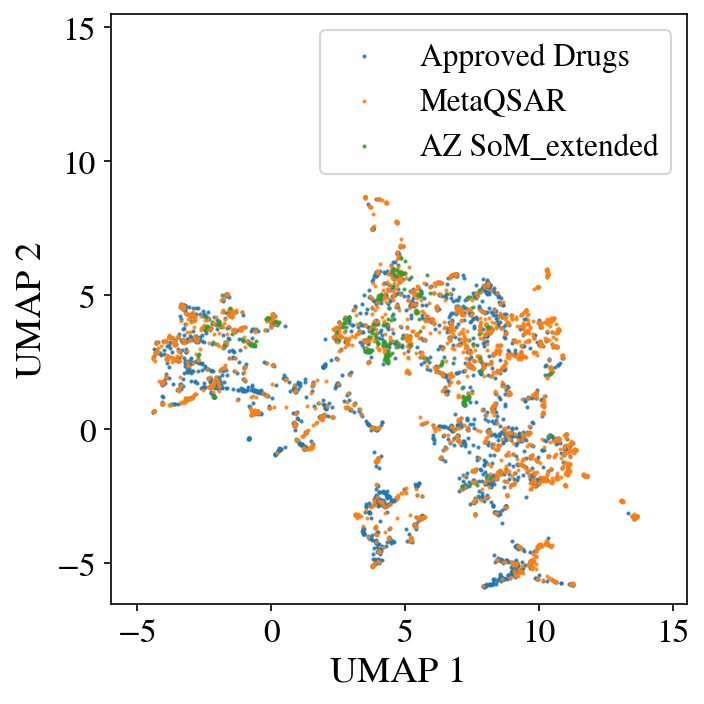

In [39]:
databases = ['Approved Drugs','MetaQSAR','AZ SoM_extended']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_umap(umapDF,databases,colors)

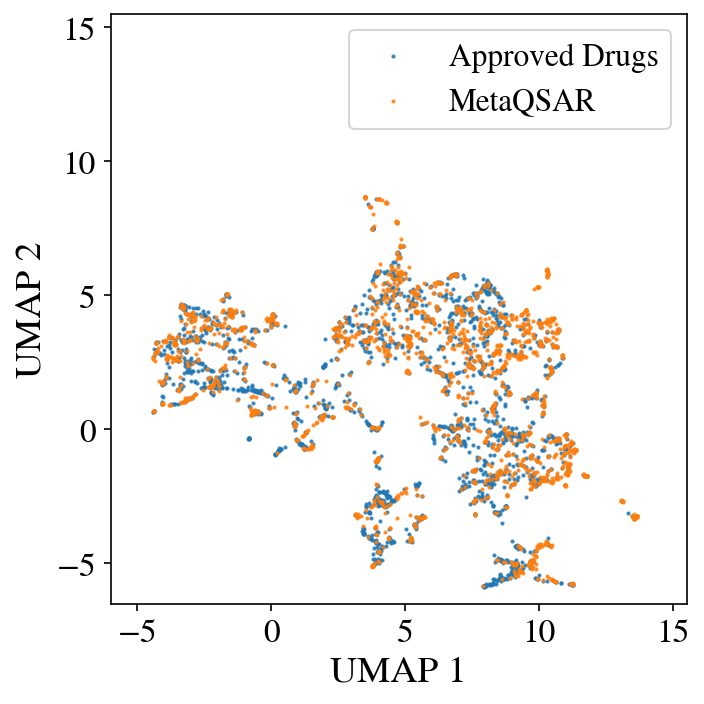

In [40]:
databases = ['Approved Drugs','MetaQSAR']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_umap(umapDF,databases,colors)

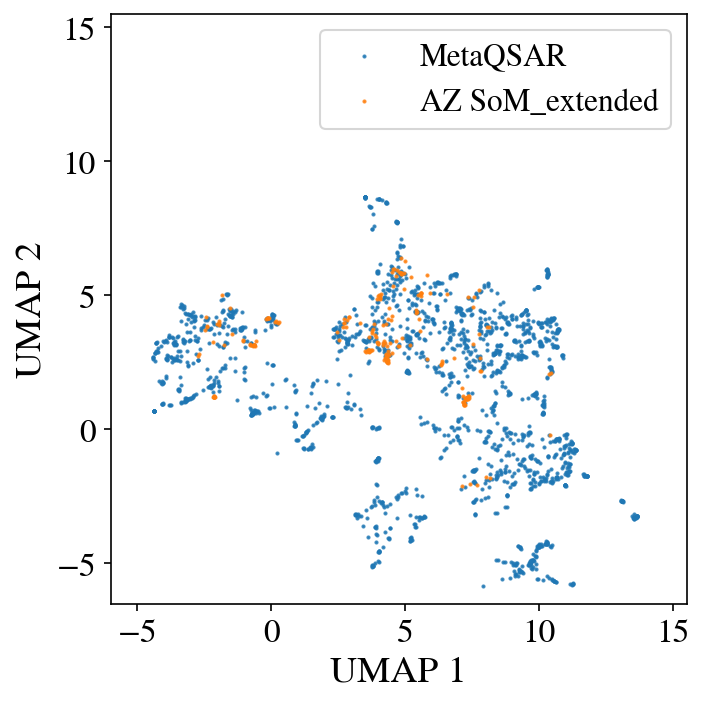

In [41]:
databases = ['MetaQSAR','AZ SoM_extended']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plot_umap(umapDF,databases,colors)